<a href="https://colab.research.google.com/github/suyesha07/PCOS_diagnosis/blob/main/PCOS_Detection_Model_withML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installations**

In [ ]:
!pip install numpy

In [ ]:
!pip install seaborn --upgrade

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
sns.__version__

'0.11.2'

# IMPORTING LIBRARIES

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from collections import Counter
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost
import lightgbm
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# LOADING DATA

In [ ]:
inf = pd.read_csv('PCOS_infertility.csv')
woinf = pd.read_excel('PCOS_data_without_infertility.xlsx', sheet_name= 'Full_new')

In [ ]:
# Looking at the data with infertile patients.

inf.head()

,Sl. No,Patient File No.,PCOS (Y/N),I beta-HCG(mIU/mL),II beta-HCG(mIU/mL),AMH(ng/mL)
0,1,10001,0,1.99,1.99,2.07
1,2,10002,0,60.80,1.99,1.53
2,3,10003,1,494.08,494.08,6.63
3,4,10004,0,1.99,1.99,1.22
4,5,10005,0,801.45,801.45,2.26


In [ ]:
# Looking at the data with non-infertile patients.

woinf.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm),Unnamed: 44
0,1.0,1.0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,...,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5,NaN
1,2.0,2.0,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,...,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7,NaN
2,3.0,3.0,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,...,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0,NaN
3,4.0,4.0,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,...,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5,NaN
4,5.0,5.0,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,...,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0,NaN


# DATA PREPROCESSING

In [ ]:
# Looking at the columns of data with non-infertile patients.

woinf.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'Weight (Kg)',
       'Height(Cm) ', 'BMI', 'Blood Group', 'Pulse rate(bpm) ',
       'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Cycle length(days)',
       'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions',
       '  I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)',
       'LH(mIU/mL)', 'FSH/LH', 'Hip(inch)', 'Waist(inch)', 'Waist:Hip Ratio',
       'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'Vit D3 (ng/mL)',
       'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)',
       'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Pimples(Y/N)',
       'Fast food (Y/N)', 'Reg.Exercise(Y/N)', 'BP _Systolic (mmHg)',
       'BP _Diastolic (mmHg)', 'Follicle No. (L)', 'Follicle No. (R)',
       'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)',
       'Unnamed: 44'],
      dtype='object')

In [ ]:
# Merging the two files as per patient file no.
# The files were sorted into two based on patients with infertility and without infertility

data = pd.merge(woinf,inf, on='Patient File No.', suffixes={'','_wo'},how='left')

In [ ]:
#Dropping the repeated features after merging.

data =data.drop(['Unnamed: 44', 'Sl. No_wo', 'PCOS (Y/N)_wo', '  I   beta-HCG(mIU/mL)_wo','II    beta-HCG(mIU/mL)_wo', 'AMH(ng/mL)_wo'], axis=1)

In [ ]:
# Changing the title of the properties.

data = data.rename(columns = {"PCOS (Y/N)":"Target"})

In [ ]:
# Looking at the merged data.

data.head()

,Sl. No,Patient File No.,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,1.0,1.0,0.0,28.0,44.6,152.0,19.300000,15.0,78.0,22.0,...,0.0,1.0,0.0,110.0,80.0,3.0,3.0,18.0,18.0,8.5
1,2.0,2.0,0.0,36.0,65.0,161.5,24.921163,15.0,74.0,20.0,...,0.0,0.0,0.0,120.0,70.0,3.0,5.0,15.0,14.0,3.7
2,3.0,3.0,1.0,33.0,68.8,165.0,25.270891,11.0,72.0,18.0,...,1.0,1.0,0.0,120.0,80.0,13.0,15.0,18.0,20.0,10.0
3,4.0,4.0,0.0,37.0,65.0,148.0,29.674945,13.0,72.0,20.0,...,0.0,0.0,0.0,120.0,70.0,2.0,2.0,15.0,14.0,7.5
4,5.0,5.0,0.0,25.0,52.0,161.0,20.060954,11.0,72.0,18.0,...,0.0,0.0,0.0,120.0,80.0,3.0,4.0,16.0,14.0,7.0


In [ ]:
# Dropping unnecessary features.

data = data.drop(["Sl. No","Patient File No."],axis = 1)

In [ ]:
data.info(verbose = True, null_counts = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541 entries, 0 to 540
Data columns (total 42 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Target                  float64
 1    Age (yrs)              float64
 2   Weight (Kg)             float64
 3   Height(Cm)              float64
 4   BMI                     float64
 5   Blood Group             float64
 6   Pulse rate(bpm)         float64
 7   RR (breaths/min)        float64
 8   Hb(g/dl)                float64
 9   Cycle(R/I)              float64
 10  Cycle length(days)      float64
 11  Marraige Status (Yrs)   float64
 12  Pregnant(Y/N)           float64
 13  No. of aborptions       float64
 14    I   beta-HCG(mIU/mL)  float64
 15  II    beta-HCG(mIU/mL)  object 
 16  FSH(mIU/mL)             float64
 17  LH(mIU/mL)              float64
 18  FSH/LH                  float64
 19  Hip(inch)               float64
 20  Waist(inch)             float64
 21  Waist:Hip Ratio         float64
 22  TS

In [ ]:
# Having a look at the data with dtype objects.

data["AMH(ng/mL)"].head()

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [ ]:
# Similarly,

data["II    beta-HCG(mIU/mL)"].head()

0      1.99
1      1.99
2    494.08
3      1.99
4    801.45
Name: II    beta-HCG(mIU/mL), dtype: object

In [ ]:
# Dealing with categorical values.
# In this database the type objects are numeric values saved as strings.
# So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')

data["II    beta-HCG(mIU/mL)"] = pd.to_numeric(data["II    beta-HCG(mIU/mL)"], errors='coerce')

In [ ]:
# Dealing with missing values. 
# Filling NA values with the median of that feature.

data['Marraige Status (Yrs)'].fillna(data['Marraige Status (Yrs)'].median(),inplace=True)

data['II    beta-HCG(mIU/mL)'].fillna(data['II    beta-HCG(mIU/mL)'].median(),inplace=True)

data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)

data['Fast food (Y/N)'].fillna(data['Fast food (Y/N)'].median(),inplace=True)

In [ ]:
# Clearing up the extra space in the column names.

data.columns = [col.strip() for col in data.columns]

# VARIABLE DESCRIPTION

In [ ]:
colors = ['#FF69D1','#970AE2']

## Categorical Variable

In [ ]:
def bar_plot(variable):
    """
     input: variable example : Target
     output: bar plot & value count
     
    """
    # Get feature
    var = data[variable]
    # Count number of categorical variable(value/sample)
    varValue = var.value_counts()
    # Visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=colors)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

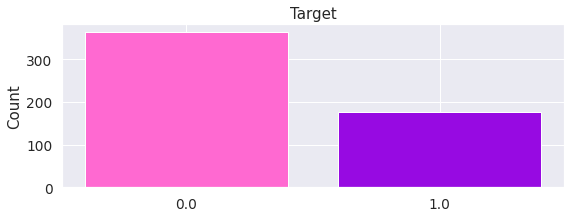

Target: 
 0.0    364
1.0    177
Name: Target, dtype: int64


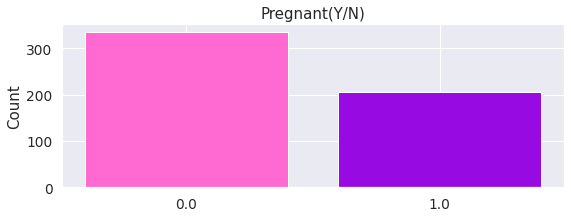

Pregnant(Y/N): 
 0.0    335
1.0    206
Name: Pregnant(Y/N), dtype: int64


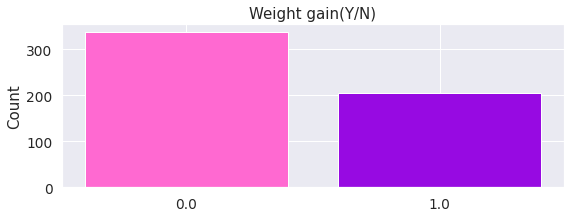

Weight gain(Y/N): 
 0.0    337
1.0    204
Name: Weight gain(Y/N), dtype: int64


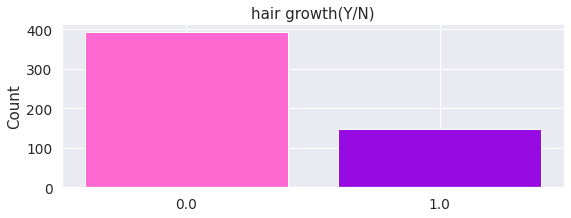

hair growth(Y/N): 
 0.0    393
1.0    148
Name: hair growth(Y/N), dtype: int64


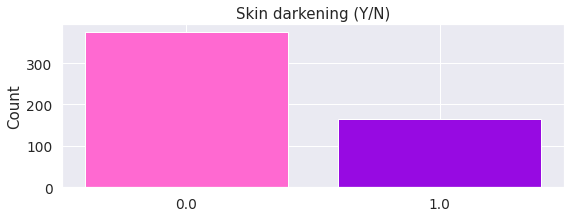

Skin darkening (Y/N): 
 0.0    375
1.0    166
Name: Skin darkening (Y/N), dtype: int64


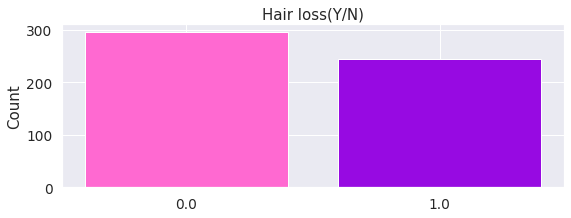

Hair loss(Y/N): 
 0.0    296
1.0    245
Name: Hair loss(Y/N), dtype: int64


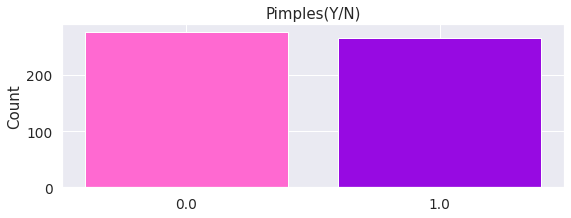

Pimples(Y/N): 
 0.0    276
1.0    265
Name: Pimples(Y/N), dtype: int64


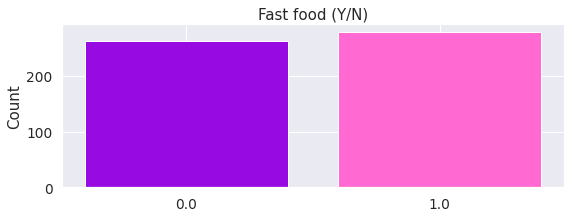

Fast food (Y/N): 
 1.0    279
0.0    262
Name: Fast food (Y/N), dtype: int64


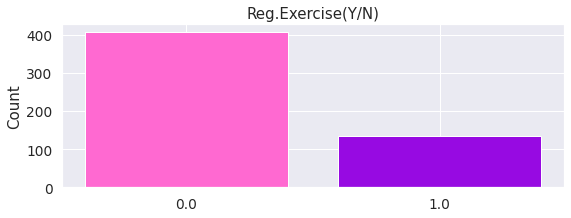

Reg.Exercise(Y/N): 
 0.0    407
1.0    134
Name: Reg.Exercise(Y/N), dtype: int64


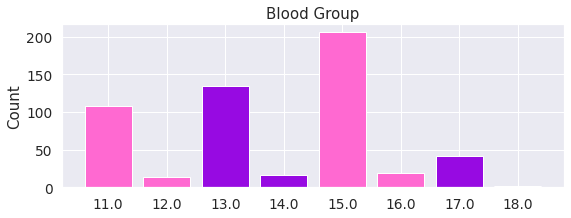

Blood Group: 
 15.0    206
13.0    135
11.0    108
17.0     42
16.0     19
14.0     16
12.0     13
18.0      2
Name: Blood Group, dtype: int64


In [ ]:
category = ["Target", "Pregnant(Y/N)", "Weight gain(Y/N)", "hair growth(Y/N)", "Skin darkening (Y/N)", "Hair loss(Y/N)", "Pimples(Y/N)", "Fast food (Y/N)", "Reg.Exercise(Y/N)", "Blood Group"]
for c in category:
    bar_plot(c)

In [ ]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50,color=colors[1])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

## Numerical Variable

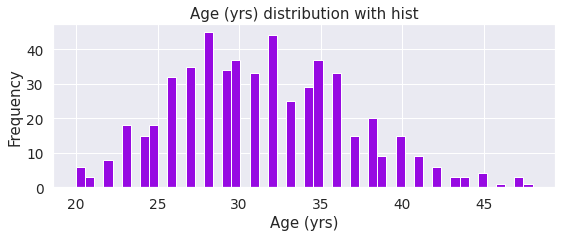

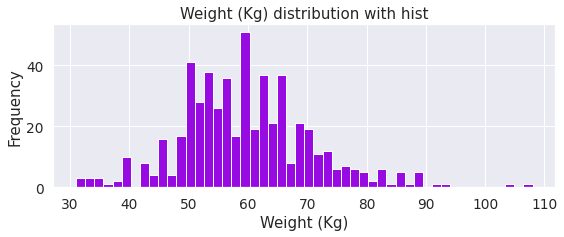

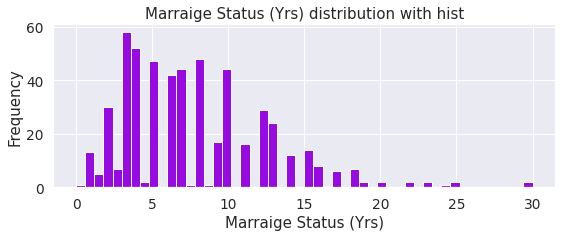

In [ ]:
numericVar = ["Age (yrs)", "Weight (Kg)","Marraige Status (Yrs)"]
for n in numericVar:
    plot_hist(n)

# EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
# Having a look at some basic statistical details.

data.describe()

,Target,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,...,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,24.311285,13.802218,73.247689,19.243993,11.160037,2.560074,...,0.489834,0.515712,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,4.056399,1.840812,4.430285,1.688629,0.866904,0.901950,...,0.500359,0.500216,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,12.417882,11.000000,13.000000,16.000000,8.500000,2.000000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,21.641274,13.000000,72.000000,18.000000,10.500000,2.000000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,24.238227,14.000000,72.000000,18.000000,11.000000,2.000000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,26.634958,15.000000,74.000000,20.000000,11.700000,4.000000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,38.900000,18.000000,82.000000,28.000000,14.800000,5.000000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


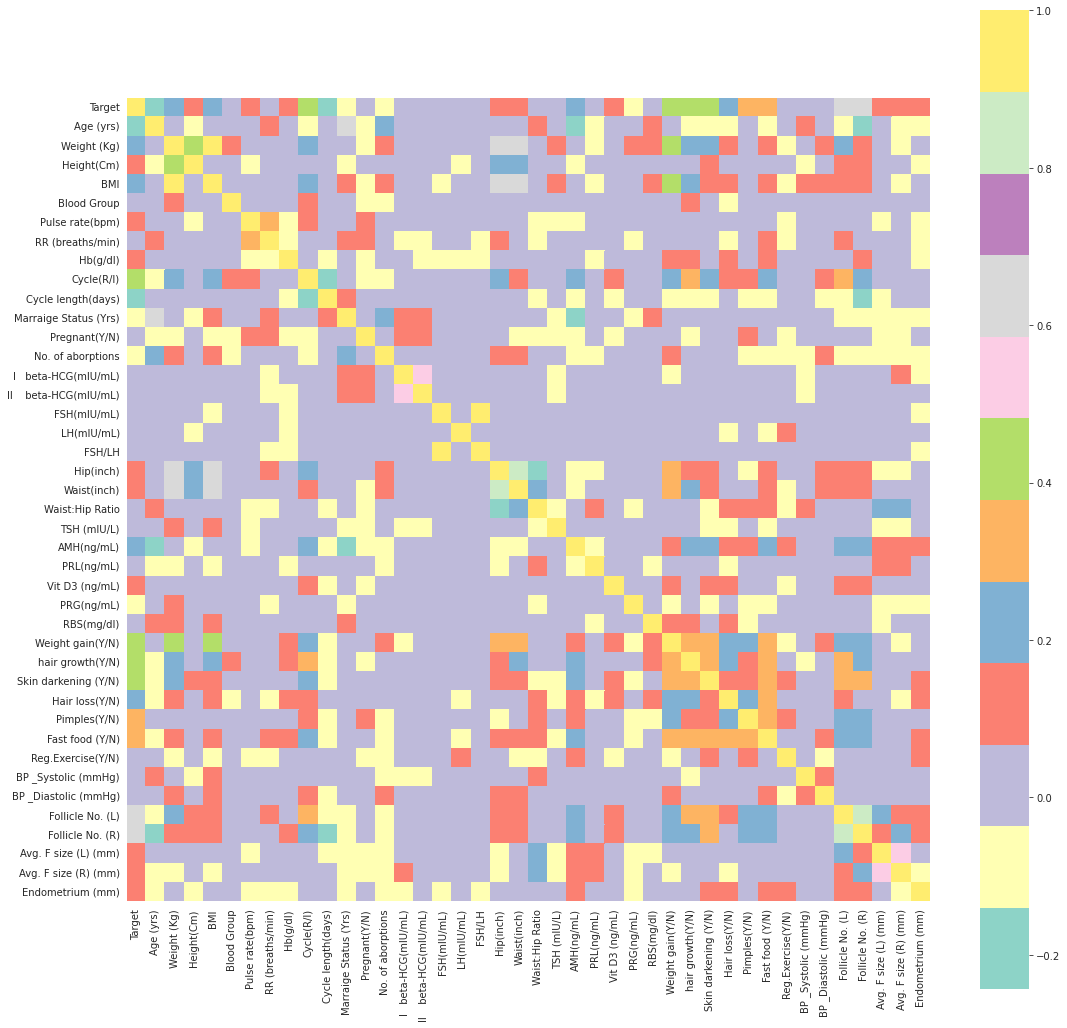

In [ ]:
# Examaning a correlation matrix of all the features.

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Set3", square=True);

In [ ]:
# How all the features correlate with the PCOS. 

corrmat['Target'].sort_values(ascending=False)

Target                    1.000000
Follicle No. (R)          0.648327
Follicle No. (L)          0.603346
Skin darkening (Y/N)      0.475733
hair growth(Y/N)          0.464667
Weight gain(Y/N)          0.441047
Cycle(R/I)                0.401644
Fast food (Y/N)           0.376183
Pimples(Y/N)              0.286077
AMH(ng/mL)                0.264141
Weight (Kg)               0.211938
BMI                       0.199534
Hair loss(Y/N)            0.172879
Waist(inch)               0.164598
Hip(inch)                 0.162297
Avg. F size (L) (mm)      0.132992
Endometrium (mm)          0.106648
Avg. F size (R) (mm)      0.097690
Pulse rate(bpm)           0.091821
Hb(g/dl)                  0.087170
Vit D3 (ng/mL)            0.085494
Height(Cm)                0.068254
Reg.Exercise(Y/N)         0.065337
LH(mIU/mL)                0.063879
RBS(mg/dl)                0.048922
BP _Diastolic (mmHg)      0.038032
RR (breaths/min)          0.036928
Blood Group               0.036433
II    beta-HCG(mIU/m

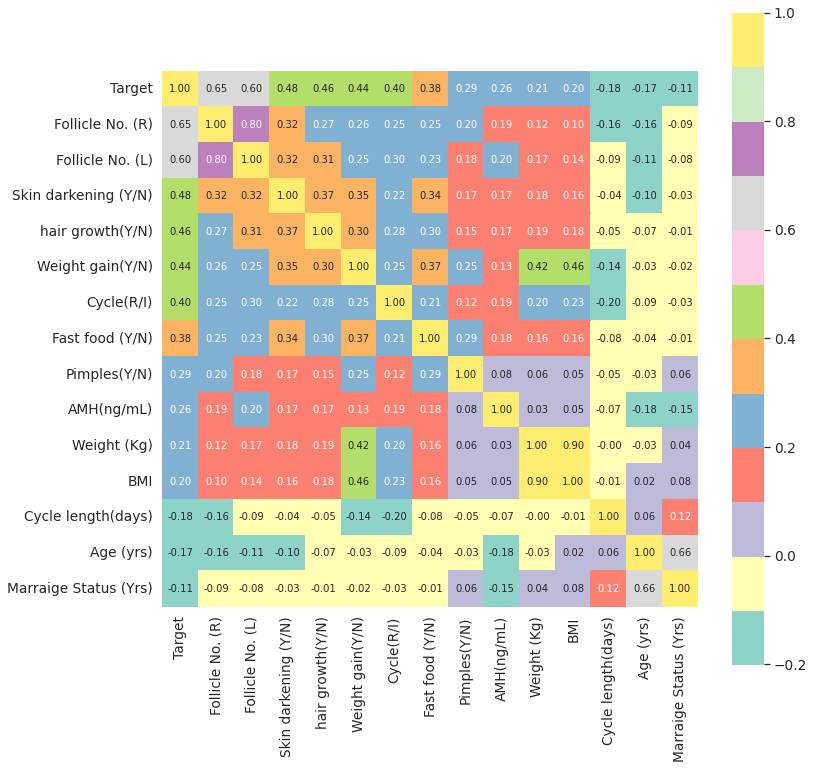

In [ ]:
# Having a look at features bearing significant correlation.

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k,'Target')['Target'].index 
cols_n = corrmat.nsmallest(l, 'Target')['Target'].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Set3", annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Patterns Of Length Of The Menstrual Cycle

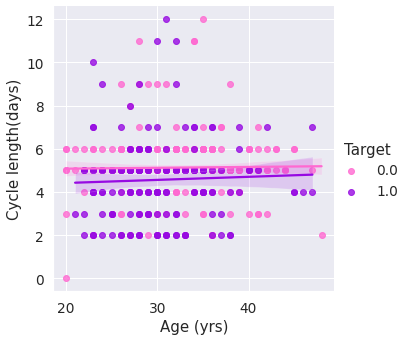

In [ ]:
# Length of menstrual phase in PCOS vs normal 

fig=sns.lmplot(data=data,x="Age (yrs)",y="Cycle length(days)", hue="Target",palette=colors)
plt.show(fig)


The length of the menstrual phase is overall consistent over different ages for normal cases. Whereas in the case of PCOD the length increased with age.

## Patterns Of BMI

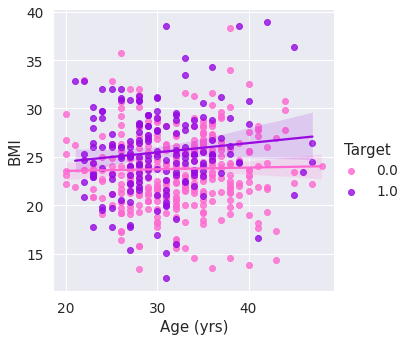

In [ ]:
# Pattern of weight gain (BMI) over years in PCOS and Normal. 

fig= sns.lmplot(data =data,x="Age (yrs)",y="BMI", hue="Target", palette= colors )
plt.show(fig)

Body mass index (BMI) is showing consistency for normal cases. Whereas for PCOS the BMI increases with age.

## Patterns Of Irregularity In Mensuration

Apparently in the feature "Cycle(R/I)" value:


*   4 indicates irregular menstrual cycle
*   2 indicates irregular menstrual cycle



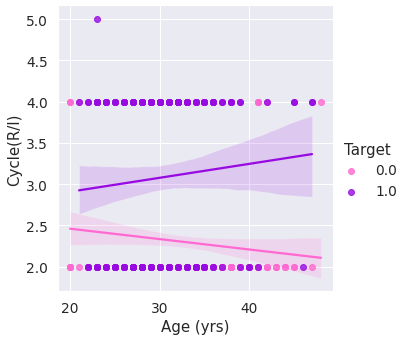

In [ ]:
# Cycle IR wrt age 

sns.lmplot(data =data,x="Age (yrs)",y="Cycle(R/I)", hue="Target",palette=colors)
plt.show()

The mensural cycle becomes more regular for normal cases with age. Whereas, for PCOS the irregularity increases with age.

## Number Of Follicles

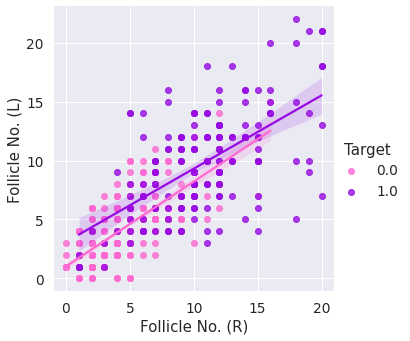

In [ ]:
# Distribution of follicles in both ovaries.

sns.lmplot(data =data,x='Follicle No. (R)',y='Follicle No. (L)', hue="Target",palette=colors)
plt.show()

The distribution of follicles in both ovaries Left and Right are not equal for women with PCOS in comparison with the "Normal" patient.

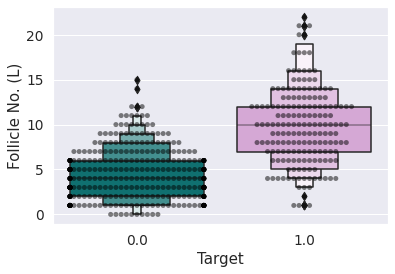

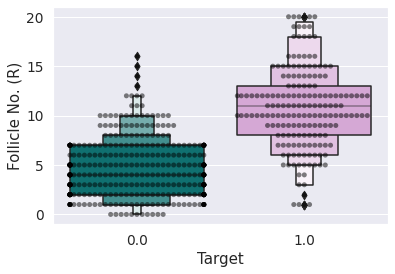

In [ ]:
# Exploring the above observation with the help of Boxplot

color = ["teal", "plum"]
features = ["Follicle No. (L)","Follicle No. (R)"]
for i in features:
    sns.swarmplot(x=data["Target"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["Target"], y=data[i], palette=color)
    plt.show()

The number of follicles in women with PCOS is higher, as expected. And are unequal as well.

## Some Miscellaneous EDA

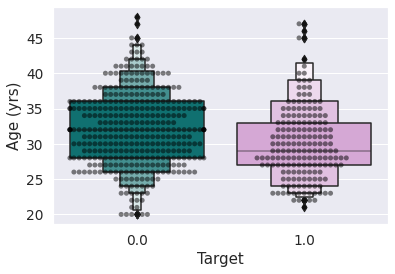

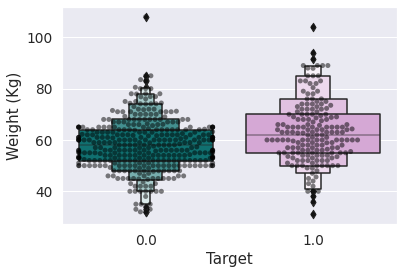

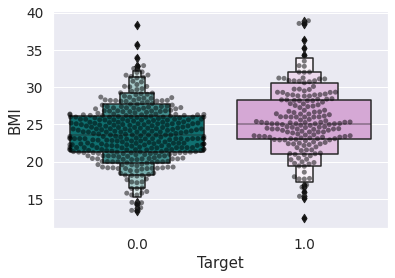

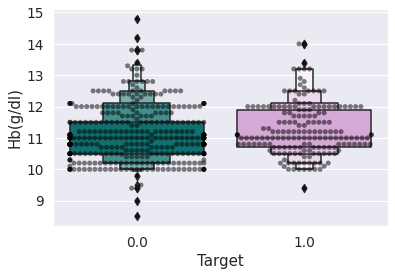

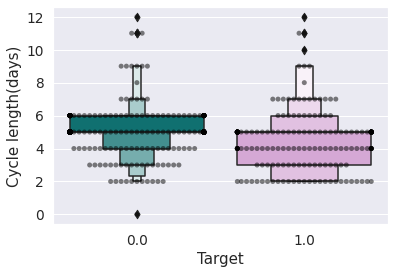

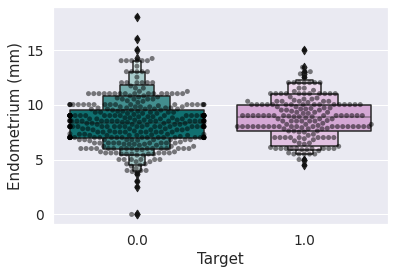

In [ ]:
features = ["Age (yrs)","Weight (Kg)", "BMI", "Hb(g/dl)", "Cycle length(days)","Endometrium (mm)" ]
for i in features:
    sns.swarmplot(x=data["Target"], y=data[i], color="black", alpha=0.5 )
    sns.boxenplot(x=data["Target"], y=data[i], palette=color)
    plt.show()


# DATA MODELING

## Train - Test Split

In [ ]:
#Assiging the features (X)and target(y).

X= data.drop(labels = ["Target"],axis = 1)
y=data.Target

In [ ]:
#Splitting the data into test and training sets.

X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [ ]:
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 378
X_test 163
y_train 378
y_test 163


## Simple Logistic Regression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 89.15
Testing Accuracy: % 80.37


# Grid Search

Here, taking 5 Machine Learning classifiers and evaluating the mean accuracy of each of them by stratified cross validation.


1.   Decision Tree
2.   SVM
3.   Random Forest
4.   KNN
5.   Logistic Regression



In [ ]:
random_state = 42
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

# Decision Tree
dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

# SVM
svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000]}

# Random Forest
rf_param_grid = {"max_features": ['auto', 'sqrt', 'log2'],
                "n_estimators":[300,500],
                "criterion":["gini"],
                'max_depth' : [4,5,6,7,8,9,10,12],}

# Logistic Regression
logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"]}

# KNN
knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}


classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [ ]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10),
                       scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(round(clf.best_score_*100,2))
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
84.37
Fitting 10 folds for each of 28 candidates, totalling 280 fits
70.65
Fitting 10 folds for each of 48 candidates, totalling 480 fits
92.06
Fitting 10 folds for each of 14 candidates, totalling 140 fits
86.79
Fitting 10 folds for each of 40 candidates, totalling 400 fits
74.07


In [ ]:
best_estimators

[DecisionTreeClassifier(max_depth=5, min_samples_split=30, random_state=42),
 SVC(C=1, gamma=0.001, random_state=42),
 RandomForestClassifier(max_depth=12, n_estimators=300, random_state=42),
 LogisticRegression(C=10.0, random_state=42),
 KNeighborsClassifier(metric='manhattan', n_neighbors=9, weights='distance')]

In [ ]:
dt = best_estimators[0]
svm = best_estimators[1]
rf = best_estimators[2]
lr = best_estimators[3]
knn = best_estimators[4]

# XGBRF and CatBoost

In [ ]:
# XGBRF Classifier
xgb_clf = xgboost.XGBRFClassifier(max_depth=3, random_state=random_state)
xgb_clf.fit(X_train,y_train)
acc_xgb_clf_train = round(xgb_clf.score(X_train, y_train)*100,2) 
acc_xgb_clf_test = round(xgb_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_xgb_clf_train)
print("Training Accuracy: % {}".format(acc_xgb_clf_train))
print("Testing Accuracy: % {}".format(acc_xgb_clf_test))

Training Accuracy: % 91.8
Testing Accuracy: % 83.44


In [ ]:
# CatBoost Classifier
cat_clf = CatBoostClassifier()
cat_clf.fit(X_train,y_train)
acc_cat_clf_train = round(cat_clf.score(X_train, y_train)*100,2) 
acc_cat_clf_test = round(cat_clf.score(X_test,y_test)*100,2)
cv_result.append(acc_cat_clf_train)
print("Training Accuracy: % {}".format(acc_cat_clf_train))
print("Testing Accuracy: % {}".format(acc_cat_clf_test))


Learning rate set to 0.0068
0:	learn: 0.6882218	total: 64.5ms	remaining: 1m 4s
1:	learn: 0.6816713	total: 78.6ms	remaining: 39.2s
2:	learn: 0.6755435	total: 91.5ms	remaining: 30.4s
3:	learn: 0.6690303	total: 112ms	remaining: 27.8s
4:	learn: 0.6625447	total: 134ms	remaining: 26.7s
5:	learn: 0.6567088	total: 149ms	remaining: 24.7s
6:	learn: 0.6512930	total: 169ms	remaining: 23.9s
7:	learn: 0.6458089	total: 189ms	remaining: 23.4s
8:	learn: 0.6419223	total: 204ms	remaining: 22.5s
9:	learn: 0.6360837	total: 211ms	remaining: 20.9s
10:	learn: 0.6301552	total: 223ms	remaining: 20s
11:	learn: 0.6239406	total: 236ms	remaining: 19.5s
12:	learn: 0.6190146	total: 250ms	remaining: 19s
13:	learn: 0.6136708	total: 264ms	remaining: 18.6s
14:	learn: 0.6081954	total: 277ms	remaining: 18.2s
15:	learn: 0.6044435	total: 292ms	remaining: 17.9s
16:	learn: 0.5995803	total: 304ms	remaining: 17.6s
17:	learn: 0.5957015	total: 318ms	remaining: 17.4s
18:	learn: 0.5907204	total: 334ms	remaining: 17.3s
19:	learn: 0.5

# RESULT

Showing the model, accuracy and confusion matrix.

In [ ]:
model_list = ['Decision Tree','SVC','RandomForest','Logistic Regression','KNearestNeighbours','XGBRF','CatBoostClassifier']

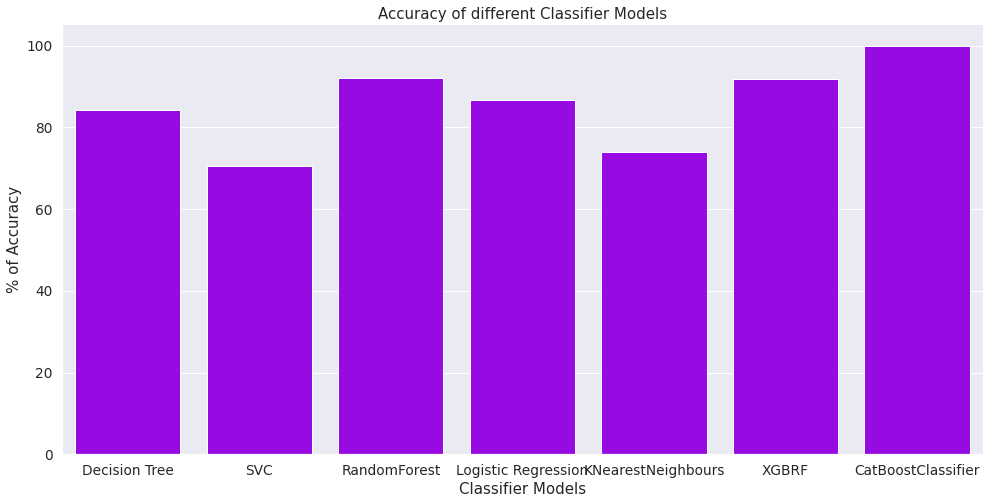

In [ ]:
fg = sns.factorplot(x = model_list, y = cv_result, size= 7, aspect=2 ,color= colors[1], saturation=5,kind='bar', data=data)
plt.title('Accuracy of different Classifier Models')
plt.xlabel('Classifier Models')
plt.ylabel('% of Accuracy')

plt.show()

In [ ]:
# Plotly Bar Chart:

import plotly.graph_objects as go
trace1 = go.Bar(
                x = model_list,
                y = cv_result,
                marker = dict(color = 'rgb(32, 55, 110)',
                              line=dict(color='rgb(0,0,0)',width=1.5)))
layout = go.Layout(title = 'Accuracy of different Classifier Models' , xaxis = dict(title = 'Classifier Models'), yaxis = dict(title = '% of Accuracy'))
fig = go.Figure(data = [trace1], layout = layout)
fig.show()


In [ ]:
model = [dt,svm,rf,lr,knn,xgb_clf,cat_clf]
predictions = []

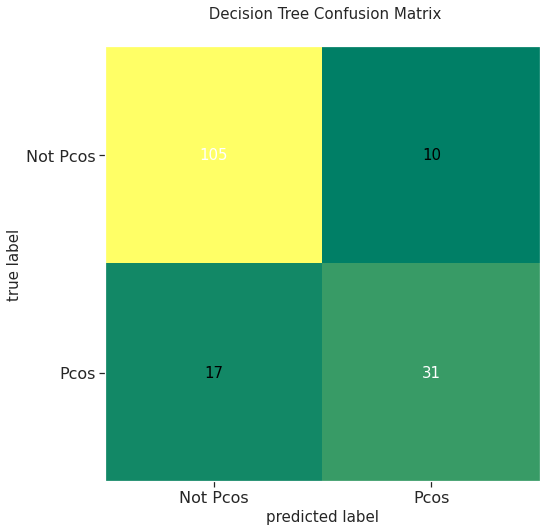

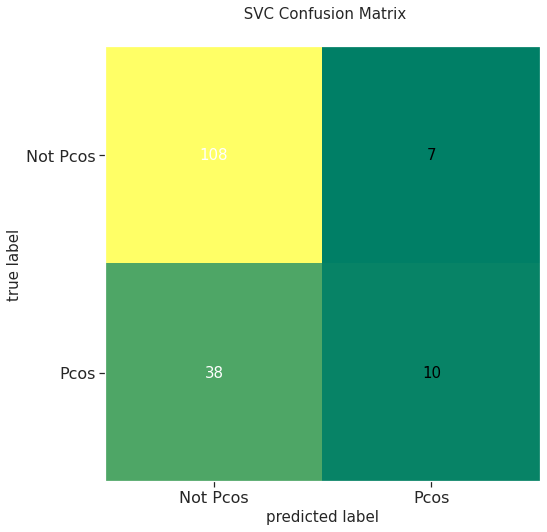

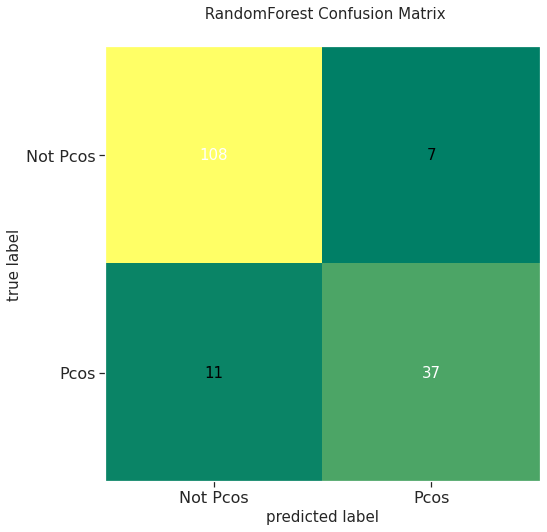

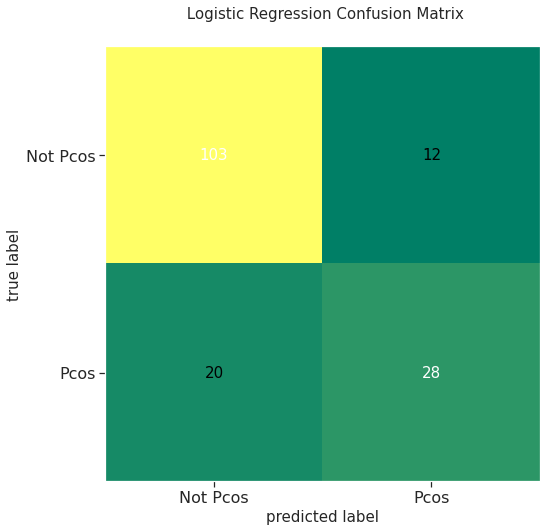

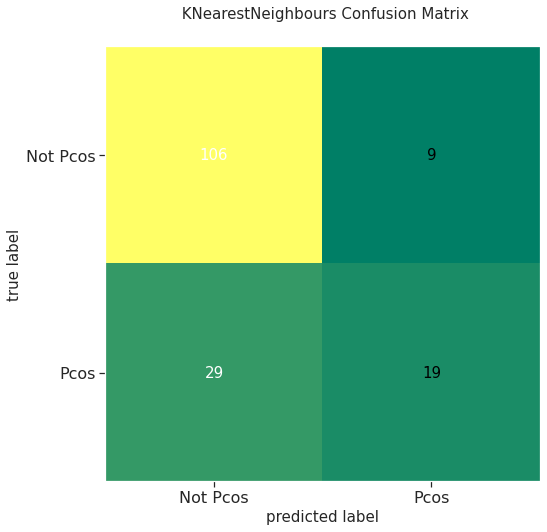

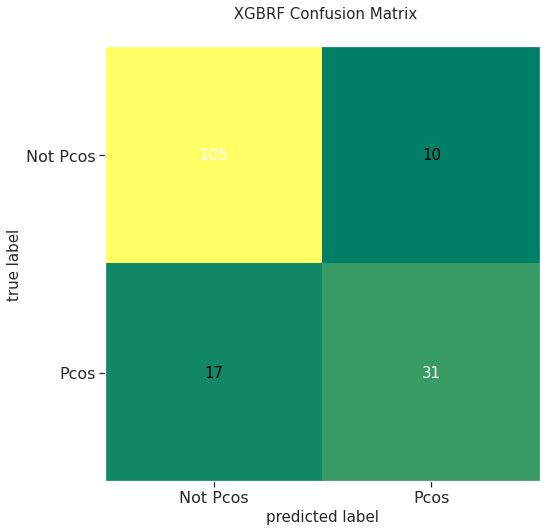

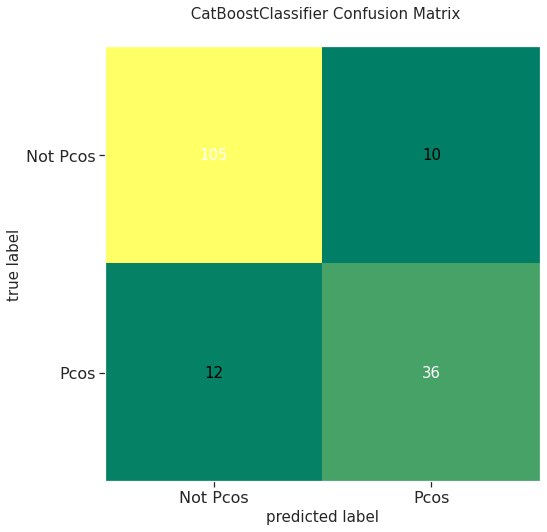

In [ ]:
for i in model:
    predictions.append(i.predict(X_test))
for j in range(7):
    cm = confusion_matrix(y_test, predictions[j])
    plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.summer)
    plt.title(" {} Confusion Matrix".format(model_list[j]))
    plt.xticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.yticks(range(2), ["Not Pcos","Pcos"], fontsize=16)
    plt.show()